In [75]:
import _cffi_backend
import numpy as np
from datasets import load_dataset
from pixel_datasets.dataset_transformations import SyntheticDatasetTransform, SimpleTorchTransform  
from pixel_datasets.pixel_dataset_generator import PretrainingDataset
from pixel_datasets.squad_dataset_for_pixel import SquadDatasetForPixel
from pixel_datasets.utils.utils import plot_arrays
from pixel_datasets.glue_dataset_generator import GlueDatasetForPixel
import wandb
from PIL import Image
from pixel_datasets.utils.squad_utils import (
    generate_pixel_mask_from_recangles,
    merge_rectangle_lines,
    convert_pixel_mask_to_patch_mask,
)

In [2]:
rng = np.random.RandomState(2)
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/squad_config.yaml", mode="disabled")
transform = SyntheticDatasetTransform(wandb.config, rng=rng)
train_dataset = SquadDatasetForPixel(config=wandb.config, transform=transform, rng=rng)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


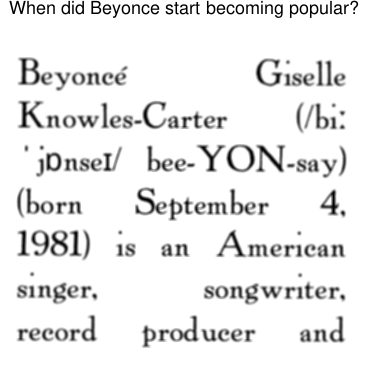

In [199]:
iterator = train_dataset.__iter__()
sample = iterator.__next__()
im = (sample["pixel_values"].numpy()).astype("float32").transpose(1, 2, 0)
mask = sample["label_mask"].numpy().astype("uint8")
mask = np.kron(mask, np.ones((16, 16)))
im[mask == 1] = im[mask == 1] - 60
im = np.clip(im, 0, 255).astype("uint8")
image = Image.fromarray(im)
image

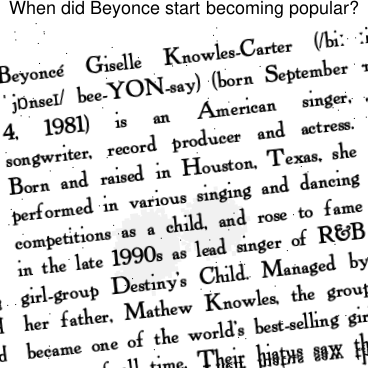

In [227]:
context = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_just_context.png")
context = np.asarray(context)
mask = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historica_squad_just_mask.png")
mask = np.asarray(mask)

question = im[: im.shape[0] - context.shape[0], :]



wandb.config.update({"rotation_max_degrees": 10}, allow_val_change=True)
wandb.config.update({"rotation_probability": 1}, allow_val_change=True)

transform = SyntheticDatasetTransform(wandb.config, rng=rng)
context, mask = transform(context.copy(), mask)
context = context.numpy().astype("uint8").transpose(1, 2, 0)

scan = np.concatenate([question, context], axis=0)
mask = np.concatenate([np.zeros((question.shape[0], mask.shape[1])), mask], axis=0)
scan = Image.fromarray(scan)
scan

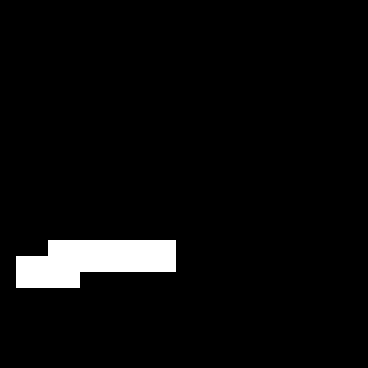

In [228]:
pixel_mask = convert_pixel_mask_to_patch_mask(np.asarray(mask),
                wandb.config.patch_base_size[0],
                wandb.config.mask_patching_tolerance,)
pixel_mask = np.kron(pixel_mask, np.ones((16, 16)))
pixel_mask = Image.fromarray(pixel_mask.astype("uint8") * 255)
pixel_mask


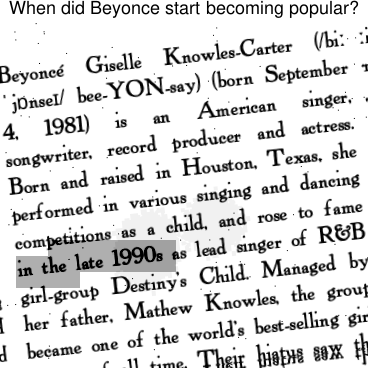

In [229]:
im = np.asarray(scan).astype("float32")
mask = np.asarray(pixel_mask)
im[mask == 255] = im[mask == 255] - 80 

im = np.clip(im, 0, 255).astype("uint8")
image = Image.fromarray(im)
image


In [230]:
image.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_final.png")

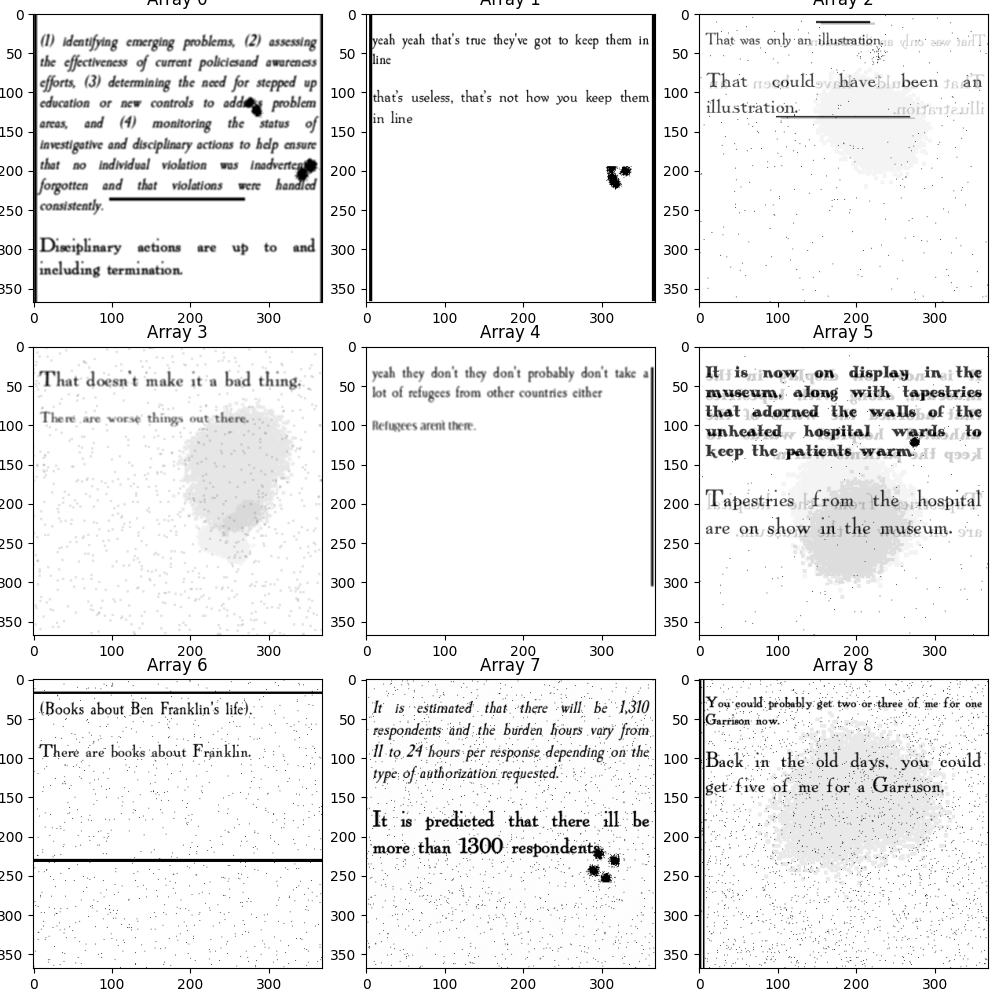

In [4]:
figures = []
for i in range(3):
    counter = 0
    for j in np.random.randint(0, len(train_dataset), 3):
        batch = train_dataset[int(j)]
        im = batch["pixel_values"].numpy().astype("uint8").transpose(1, 2, 0)
        
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

In [4]:
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/pretraining_config.yaml", mode="disabled")
text_dataset = load_dataset("wikipedia", "20220301.simple")


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:randomizing dataset with worker id=0 and epoch=0
INFO:root:randomizing dataset with worker id=0 and epoch=1
INFO:root:randomizing dataset with worker id=0 and epoch=2


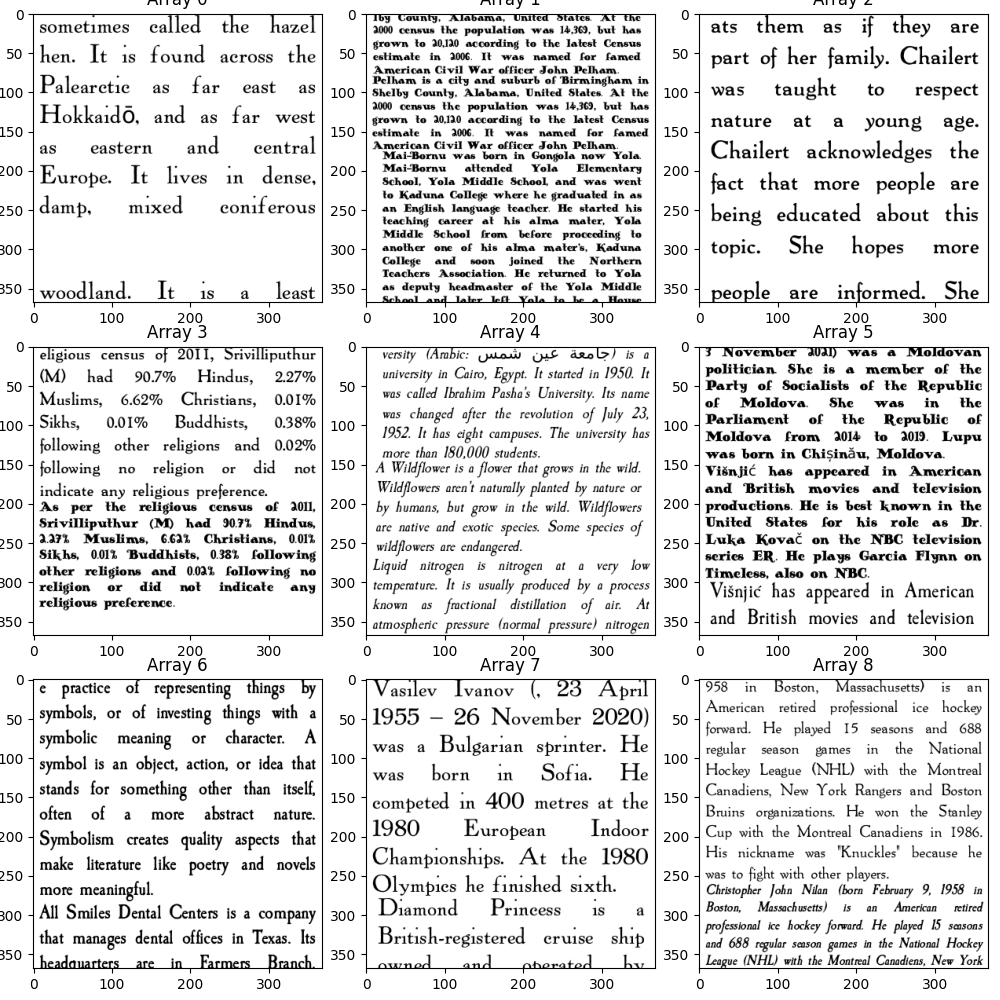

In [5]:
rng = np.random.RandomState(21)

transform = SimpleTorchTransform(wandb.config, rng=rng)
train_dataset = PretrainingDataset(wandb.config, text_dataset["train"], transform, rng=rng)

figures = []
for i in range(3):
    train_dataset.set_epoch(i)
    counter = 0
    for batch in train_dataset:
        if counter == 3:
            break
        im = (batch["pixel_values"].numpy() * 255).astype("uint8").transpose(1, 2, 0)
        
        mask = batch["patch_mask"].numpy().reshape(23, 23)
        mask = np.kron(mask, np.ones((16, 16))).astype("uint8")
        
        # im = im * (1 - mask[..., None])
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

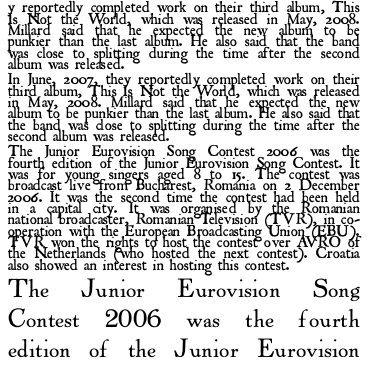

In [59]:
sample = train_dataset.__iter__().__next__()
im = (sample["pixel_values"].numpy() * 255).astype("uint8").transpose(1, 2, 0)
image = Image.fromarray(im)
image

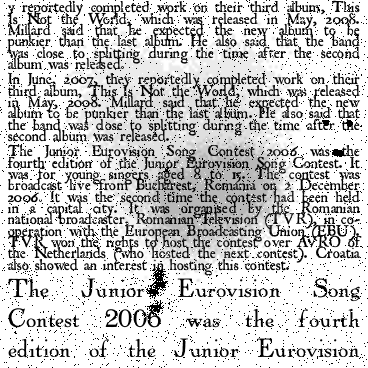

In [97]:
transform = SyntheticDatasetTransform(wandb.config, rng=rng)

with_augs = transform(sample["pixel_values"].numpy()[0] * 255)
with_augs = with_augs.numpy().astype("uint8").transpose(1, 2, 0) 
image = Image.fromarray(with_augs)
image

In [98]:
image.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/pretraining_sample_with_augmentations.png")

In [76]:
with_augs

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)